# pyISC Example: Anomaly Detection with Classes
In this example, we extend the multivariate example to the use of classes. ISC also makes it possible to compute the anomaly score for different classes, so that apples are compared to apples an d not to oranges. In addition, it is also possibel to the anomaly detector to classify unknwon examples.

In [2]:
import pyisc;
import numpy as np
from scipy.stats import poisson, norm, multivariate_normal
%matplotlib inline
from pylab import plot, figure

## Data with Classification
Create a data set with 3 columns from different probablity distributions.

In [16]:
n_classes = 3
normal_len = 10000
anomaly_len = 15
data = None
for i in range(n_classes):
    po_normal = poisson(10+i)
    po_normal2 = poisson(2+i)
    gs_normal = norm(1+i, 12)
    tmp = np.column_stack(
        [
            [1] * (normal_len),
            list(po_normal.rvs(normal_len)),
            list(po_normal2.rvs(normal_len)),
            list(gs_normal.rvs(normal_len)),
            [i] * (normal_len),
        ]
    )
    if data is None:
        data = tmp
    else:
        data = np.r_[data,tmp]
# Add anomalies
for i in range(n_classes):
    po_anomaly = poisson(25+i)
    po_anomaly2 = poisson(3+i)
    gs_anomaly = norm(2+i,30)

    tmp = np.column_stack(
        [
            [1] * (anomaly_len),
            list(po_anomaly.rvs(anomaly_len)),
            list(po_anomaly2.rvs(anomaly_len)),
            list(gs_anomaly.rvs(anomaly_len)),
            [i] * (anomaly_len),
        ]
    )
    if data is None:
        data = tmp
    else:
        data = np.r_[data,tmp]

## Anomaly Detector
Create an anomaly detector using as first argument the used statistical models. The we use  
- a onesided Poisson distribution for modelling the first fequency column (column 1) (as in the first example),
- a twosided Poisson distribution for the second frequency column (column 2),
- and a Gaussin (Normal) distribution for the last column (column 3).

Given that we now have more than one variable, it is necessary to also add a method to combine the output from the statistical models, which in this case is the maximum anomaly score of each component model:

In [17]:
anomaly_detector = pyisc.AnomalyDetector(
    component_models=[
        pyisc.P_PoissonOnesided(1,0), # columns 1 and 0
        pyisc.P_Poisson(2,0), # columns 2 and 0
        pyisc.P_Gaussian(3) # column 3
    ],
    output_combination_rule=pyisc.cr_max
)

Train the anomaly detector

In [18]:
anomaly_detector.fit(data, y=4); # y is the class column or an array with classes

Compute the anomaly scores for each data point

In [6]:
scores = anomaly_detector.anomaly_score(data, y=4)

## Anomaly Scores with Classes
Now we can print some example of normal frequencies vs. anomaly scores for the 15 first normal data points:

In [7]:
from pandas import DataFrame
df= DataFrame(data[:15], columns=['Class','#Days', 'Freq1','Freq2','Measure'])
df['Anomaly Score'] = scores[:15]
print df.to_string()

    Class  #Days  Freq1      Freq2  Measure  Anomaly Score
0       1      8      0  -7.697829        0       1.278852
1       1      7      1  -1.986374        0       0.229776
2       1     11      1   4.321750        0       0.299526
3       1     10      2 -13.608744        0       1.485177
4       1      9      1  -5.697421        0       0.543436
5       1     15      0 -10.716751        0       2.487084
6       1     10      1   8.608478        0       0.645070
7       1     13      1   0.740692        0       1.570813
8       1      8      3  -8.460878        0       1.126847
9       1      9      2   2.373379        0       0.098839
10      1      7      1  -8.199543        0       0.804841
11      1      9      2  -2.180858        0       0.229719
12      1     17      0   1.155583        0       3.615028
13      1      9      1  11.452048        0       0.959838
14      1      8      2  -9.418372        0       0.944151


The anomalous frequencies vs. anomaly scores for the 15 anomalous data points:

In [8]:
df= DataFrame(data[-45:], columns=['#Days', 'Freq1','Freq2','Measure','Class'])
df['Anomaly Score'] = scores[-45:]
print df.to_string()

    #Days  Freq1  Freq2    Measure  Class  Anomaly Score
0       1     33      3 -16.019313      0      18.737237
1       1     23      2   1.292442      0       8.133544
2       1     35      3 -39.878326      0      21.236506
3       1     30      3   3.261550      0      15.208356
4       1     28      6 -29.670542      0      13.012713
5       1     22      4  58.718210      0      13.336878
6       1     19      1 -42.820249      0       8.188949
7       1     30      1  46.779072      0      15.208356
8       1     20      3   3.783350      0       5.674221
9       1     27      3 -10.263894      0      11.964916
10      1     21      3  24.046144      0       6.451688
11      1     19      1  15.276674      0       4.941169
12      1     20      5 -73.381322      0      21.117687
13      1     27      2  -2.798956      0      11.964916
14      1     23      5  36.579071      0       8.133544
15      1     29      3 -16.861937      1      12.192423
16      1     27      1 -21.120

As can be seen above, the anomalous data also have higher anomaly scores than the normal frequencies as it should be.</b><br/><br/>
This becomes even more visible if we plot the anomaly scores (y-axis) against each data point (x-axis): 

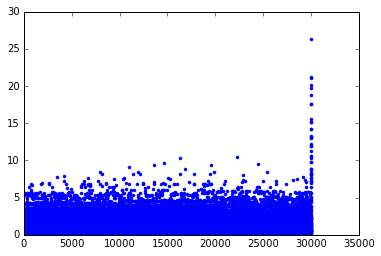

In [9]:
plot(scores, '.');

We can also look at the details of each column in terms of their individual anomaly scores:

In [10]:
score_details = anomaly_detector.anomaly_score_details(data,y=4)

In [11]:
df= DataFrame(data[-45:], columns=['#Days', 'Freq1','Freq2','Measure','Class'])
df['Anomaly:Freq1'] = [detail[2][0] for detail in score_details[-45:]]   # Anomaly Score of Freq1
df['Anomaly:Freq2'] = [detail[2][1] for detail in score_details[-45:]]   # Anomaly Score of Freq2
df['Anomaly:Measure'] = [detail[2][2] for detail in score_details[-45:]] # Anomaly Score of Measure
df['Anomaly Score'] = [detail[0] for detail in score_details[-45:]]      # Combined Anomaly Score
df

,#Days,Freq1,Freq2,Measure,Class,Anomaly:Freq1,Anomaly:Freq2,Anomaly:Measure,Anomaly Score
0,1,33,3,-16.019313,0,18.737237,1.126847,1.841315,18.737237
1,1,23,2,1.292442,0,8.133544,0.067769,0.022936,8.133544
2,1,35,3,-39.878326,0,21.236506,1.126847,7.269857,21.236506
3,1,30,3,3.261550,0,15.208356,1.126847,0.165193,15.208356
4,1,28,6,-29.670542,0,13.012713,4.094353,4.512347,13.012713
5,1,22,4,58.718210,0,7.271971,1.942310,13.336878,13.336878
6,1,19,1,-42.820249,0,4.941169,0.229776,8.188949,8.188949
7,1,30,1,46.779072,0,15.208356,0.229776,8.865386,15.208356
8,1,20,3,3.783350,0,5.674221,1.126847,0.205888,5.674221
9,1,27,3,-10.263894,0,11.964916,1.126847,1.045506,11.964916


Above, the last column corresponds to the same anomaly score as before, where we can se that it corresponds to the maximum of the individual anomaly score to the left, thus, it is the result of the combination rule specified to the anomaly detector.

## Anomaly Detector as Classifier
Let us create a data set with unkown classes from the same distributions as above:

In [19]:
data2 = None
true_classes = []
length = 1000
for i in range(n_classes):
    po_normal = poisson(10+i)
    po_normal2 = poisson(2+i)
    gs_normal = norm(1+i, 12)
    tmp = np.column_stack(
        [
            [1] * (length),
            list(po_normal.rvs(length)),
            list(po_normal2.rvs(length)),
            list(gs_normal.rvs(length)),
            [None] * (length),
        ]
    )
    
    true_classes += [i] * length
    
    if data2 is None:
        data2 = tmp
    else:
        data2 = np.r_[data2,tmp]

Then, we can also use the anomaly detector as a classifier to predict the class for each instance as below:

In [20]:
from pandas import DataFrame
from sklearn.metrics import accuracy_score
result = DataFrame(columns=['Algorithm','Accuracy'])
clf = pyisc.SklearnClassifier.clf(anomaly_detector)
predicted_classes = clf.predict(data2)
acc = accuracy_score(true_classes, predicted_classes)
result.loc[0] = ['pyISC classifier', acc]

[0 1 2]


We can also compare it to some available classifiers in Scikit-learn (http://scikit-learn.org/):

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

X = data.T[:-1].T
y = data.T[-1]
count = 1
for name, clf in zip(['GaussianNB',
                      'KNeighborsClassifier', 
                      'RandomForestClassifier'],
                     [GaussianNB(), 
                      KNeighborsClassifier(n_neighbors=1000,weights='distance'), 
                      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]):
    clf.fit(X,y);

    predicted_classes_SK= clf.predict(data2.T[:-1].T)
    acc = accuracy_score(true_classes,predicted_classes_SK)
    result.loc[count] = [name, acc]
    count += 1

result

,Algorithm,Accuracy
0,pyISC classifier,0.520333
1,GaussianNB,0.510000
2,KNeighborsClassifier,0.488000
3,RandomForestClassifier,0.509000


The pyISC classifier performce better, most likely due to being closer to using the true distributions.